## Initialize

In [23]:
%%capture
!pip install backtrader
!pip install --upgrade mplfinance
!pip install -U vectorbt
!pip install quantstats

In [58]:
# Imports
import pandas as pd
import backtrader as bt
import datetime
import os
import numpy as np
import time
import vectorbt as vbt
import shutil
import quantstats as qs
import matplotlib.pyplot as plt


In [25]:
%%capture
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [100]:
# Import helper modules for backtrader
helper1 = "/content/gdrive/MyDrive/Algorithmic Trading System (ATS)/Code/helper.py"
helper2 = "/content/gdrive/MyDrive/Algorithmic Trading System (ATS)/Code/trade_list.py"
shutil.copy(helper1,  f'{os.getcwd() + "/" + "helper.py"}')
shutil.copy(helper2,  f'{os.getcwd() + "/" + "trade_list.py"}')

import trade_list as tl
from helper import mlpplot, get_trade_list, get_indicators, get_summary_stats

In [101]:
def resample_ohlc(df, timeframe):
    """
    Resamples an OHLC DataFrame to the specified timeframe (in minutes).
    Valid timeframes are: 5, 15, 30, 45, 60.
    Returns a new DataFrame with the resampled data.
    """
    df.index = df['datetime']

    valid_timeframes = [5, 15, 30, 45, 60]
    if timeframe not in valid_timeframes:
        raise ValueError(f"Invalid timeframe: {timeframe}. Valid timeframes are: {valid_timeframes}")

    # Calculate the resampling frequency
    resample_freq = f"{timeframe}T"

    # Resample OHLC data to the desired timeframe
    ohlc_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
    df_resampled = df.resample(resample_freq).apply(ohlc_dict)

    # Drop any rows with missing data
    df_resampled.dropna(inplace=True)
    df_resampled['datetime'] = df_resampled.index
    return df_resampled

def dataframe_to_bt_feed(data):
    return bt.feeds.PandasData(dataname = data,
                              datetime = 'datetime',
                              open= 'open', high= 'high',
                              low= 'low', close= 'close',
                              volume = 'volume')

## Load, Trim and resample data

In [102]:
datapath_1m = "/content/gdrive/MyDrive/Algorithmic Trading System (ATS)/Data/Historical/Processed/TwelveData_1m/SPY_1m.csv"

In [103]:
data_1m = pd.read_csv(datapath_1m, date_parser=True).drop('Unnamed: 0', axis=1)
data_1m['datetime'] = pd.to_datetime(data_1m['datetime'])
data_1m.index = data_1m['datetime']


In [104]:
# Trim data 
first_day = min(data_1m["datetime"].dt.date) 
last_day = max(data_1m["datetime"].dt.date) 

def trim_to_date_range(data, first_day, last_day):
    return data[(data['datetime'].dt.date >= first_day) & (data['datetime'].dt.date <= last_day)]



In [105]:
# trim and resample
data_1m = trim_to_date_range(data_1m, first_day, last_day)
data_5m = resample_ohlc(data_1m, 5).dropna()
data_15m = resample_ohlc(data_1m, 15).dropna()

## Backtest Strategy

This is a multi-timeframe moving average crossover strategy

We use 3 Timeframes data:
1. Timeframe 0: 1 min close data
2. Timeframe 1: 5 min close data
3. Timeframe 2: 15 min close data

Further, we use 3 moving averages in all three timeframes:
1. Fast SMA
2. Medium SMA
3. Slow SMA

Entry and Exit Conditions
*   Long Trades
  *   Entry Conditions:
      *   If in time frame 2, fast_sma > medium_sma > slow_sma and 
      *   In time frame 1, fast_sma > medium_sma > slow_sma
      *   In time frame 0, fast_sma > medium_sma > slow_sma
  *   Exit Conditions:
      *   In time frame 1, fast_sma crosses below medium_sma 
*   Short Trades
  *   Entry Conditions:
      *   If in time frame 2, fast_sma < medium_sma < slow_sma and 
      *   In time frame 1, fast_sma < medium_sma < slow_sma
      *   In time frame 0, fast_sma < medium_sma < slow_sma
  *   Exit Conditions:
      *   In time frame 1, fast_sma crosses above medium_sma 



### Backtest using Backtrader

In [106]:
# Define a custom indicator that wraps the pandas EMA calculation
class PandasEMA(bt.Indicator):
    lines = ('ema', )

    def __init__(self, period):
        self.params.period = period

    def next(self):
        if len(self.data) >= self.params.period:
            self.lines.ema[0] = pd.Series(self.data.get(size=self.params.period)).ewm(span=self.params.period).mean().iloc[-1]

class ThreeTimeFrameMeanReversion(bt.Strategy):
    params = (
        ('slow_prd', 7),
        ('med_prd', 3),
        ('fast_prd', 2)
    )

    def __init__(self):

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.portfolio_pct = 0.5

        # TimeFrame 0 MovingAverage indicators
        self.vr_tf0_ema_slow = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.slow_prd)
        self.vr_tf0_ema_med = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.med_prd)
        self.vr_tf0_ema_fast = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.fast_prd)

        # TimeFrame 1 MovingAverage indicators
        self.vr_tf1_ema_slow = bt.indicators.SimpleMovingAverage(self.data1.close, period=self.params.slow_prd)
        self.vr_tf1_ema_med = bt.indicators.SimpleMovingAverage(self.data1.close, period=self.params.med_prd)
        self.vr_tf1_ema_fast = bt.indicators.SimpleMovingAverage(self.data1.close, period=self.params.fast_prd)

        # TimeFrame 2 MovingAverage indicators
        self.vr_tf2_ema_slow = bt.indicators.SimpleMovingAverage(self.data2.close, period=self.params.slow_prd)
        self.vr_tf2_ema_med = bt.indicators.SimpleMovingAverage(self.data2.close, period=self.params.med_prd)
        self.vr_tf2_ema_fast = bt.indicators.SimpleMovingAverage(self.data2.close, period=self.params.fast_prd)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            self.bar_executed = len(self)

        self.order = None

    def notify_trade(self, trade):

        if not trade.isclosed:
            return

    def get_max_num_stocks(self):
        pos_size = self.broker.get_value() * self.portfolio_pct
        price = self.data.close[0]
        return int(pos_size / price)

        
    def next(self):
                    
        # If an order is pending, we cannot send a 2nd one
        if self.order:
            return

        # Entry Conditions
        if not self.position:  # Are we in position

            ## Long Entry 
            # In Timeframe 2
            if self.vr_tf2_ema_fast[0] > self.vr_tf2_ema_med[0] > self.vr_tf2_ema_slow[0]:
                # in Timeframe 1
                if self.vr_tf1_ema_fast[0] > self.vr_tf1_ema_med[0] > self.vr_tf1_ema_slow[0]:
                    # in Timeframe 0 -- 1 minute
                    if self.vr_tf0_ema_fast[0] > self.vr_tf0_ema_med[0] > self.vr_tf0_ema_slow[0]:
                        # All conditions met then buy
                        max_num_stocks = self.get_max_num_stocks()
                        self.order_target_size(target=max_num_stocks)
    

            ## Short Entry
            # In Timeframe 2
            if self.vr_tf2_ema_fast[0] < self.vr_tf2_ema_med[0] < self.vr_tf2_ema_slow[0]:
                # in Timeframe 1
                if self.vr_tf1_ema_fast[0] < self.vr_tf1_ema_med[0] < self.vr_tf1_ema_slow[0]:
                    # in Timeframe 0 -- 1 minute
                    if self.vr_tf0_ema_fast[0] < self.vr_tf0_ema_med[0] < self.vr_tf0_ema_slow[0]:
                        # All conditions met then sell
                        max_num_stocks = self.get_max_num_stocks()
                        self.order_target_size(target=-max_num_stocks)


        # Exit Market Condition
        else:
            # Exit Long   
            if self.position.upopened > 0 and self.vr_tf1_ema_fast[0] < self.vr_tf1_ema_med[0]:
                # self.order = self.sell()
                self.order = self.close()

            # Exit short position
            elif self.position.upopened < 0 and self.vr_tf1_ema_fast[0] > self.vr_tf1_ema_med[0]:
                # self.order = self.buy()
                self.order = self.close()



In [107]:
def run_backtest(data, slow_prd, med_prd, fast_prd):

    data0 = dataframe_to_bt_feed(data[0])
    data1 = dataframe_to_bt_feed(data[1])
    data2 = dataframe_to_bt_feed(data[2])
    
    # initilize cerebro
    cerebro = bt.Cerebro()

    # add data
    cerebro.adddata(data0)
    cerebro.adddata(data1)
    cerebro.adddata(data2)

    # set cash
    cerebro.broker.setcash(10000.0)

    cerebro.addstrategy(ThreeTimeFrameMeanReversion, slow_prd = slow_prd, med_prd = med_prd, fast_prd = fast_prd)

    # set commission
    cerebro.broker.setcommission(commission=0.0005, margin = None)

    # Add analysers 
    cerebro.addanalyzer(tl.trade_list, _name='trade_list')
    
    # run backtest
    results = cerebro.run(tradehistory=True)

    # get results
    df_trade = get_trade_list(results)


    return df_trade

In [108]:
# Hyperparameters used 
slow_prd, med_prd, fast_prd = 10, 8, 5

In [109]:
starttime = datetime.datetime.now()
df_trade = run_backtest([data_1m, data_5m, data_15m], slow_prd, med_prd, fast_prd)
print("Time taken by Backtrader is ", (datetime.datetime.now() - starttime).total_seconds())

Time taken by Backtrader is  45.450013


In [110]:
df_trade.index = df_trade['DateTimeOut']
df_trade_res = df_trade['Profit|Loss'].resample('D').sum()
print("Sharpe ratio of the backtest is: ", qs.stats.sharpe(df_trade_res))

Sharpe ratio of the backtest is:  -1.84129887948307


In [111]:
print("The trade list is as folows")
df_trade

The trade list is as folows


,OrderType,PriceIn,PriceOut,PctChange%,Profit|Loss,Profit|LossRatio|BrokerValue,PositionSize,MaxTradeValue,CummProfitLoss,TradeDurationBars,Profit|Loss/Bar,MaxFavourableExcrusion,MaxAdverseExcrusion,DateTimeIn,DateTimeOut
DateTimeOut,,,,,,,,,,,,,,,
2022-01-03 15:11:00,long,468.412027,469.671411,0.27,7.903420,0.079,10,4684.120272,7.903420,110,0.07,0.336,-0.044,2022-01-03 13:21:00,2022-01-03 15:11:00
2022-01-03 15:41:00,long,469.897716,469.705847,-0.04,-6.616709,-0.066,10,4698.977162,1.286712,5,-1.32,0.032,-0.117,2022-01-03 15:36:00,2022-01-03 15:41:00
2022-01-04 10:06:00,long,469.809166,471.491614,0.36,12.117977,0.121,10,4698.091658,13.404689,45,0.27,0.519,-0.081,2022-01-03 15:51:00,2022-01-04 10:06:00
2022-01-04 14:41:00,short,468.412027,469.395921,0.21,-29.055950,-0.291,-20,-9368.240543,-15.651262,25,-1.16,-0.000,-0.256,2022-01-04 14:07:00,2022-01-04 14:41:00
2022-01-05 09:31:00,long,470.261747,469.700947,-0.12,-10.307810,-0.103,10,4702.617470,-25.959071,45,-0.23,0.209,-0.201,2022-01-04 15:16:00,2022-01-05 09:31:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-14 10:36:00,long,414.329990,411.959990,-0.57,-27.831450,-0.325,10,4143.299900,-1446.583721,25,-1.11,0.174,-0.705,2023-02-14 10:11:00,2023-02-14 10:36:00
2023-02-14 12:01:00,short,408.620000,410.060000,0.35,-18.493400,-0.217,-10,-4086.200000,-1465.077121,17,-1.09,0.027,-0.352,2023-02-14 11:44:00,2023-02-14 12:01:00
2023-02-14 13:41:00,long,413.200010,412.725010,-0.11,-8.879625,-0.104,10,4132.000100,-1473.956746,23,-0.39,0.085,-0.252,2023-02-14 13:18:00,2023-02-14 13:41:00


### Backtest with VectorBT

In [112]:
def get_entry_exit_signals(data_1m, data_5m, data_15m, ma_periods):
    slow_prd, med_prd, fast_prd = ma_periods[0], ma_periods[1], ma_periods[2]

    # Resample the dataframes to a common frequency
    data = data_1m.resample('1T').last().dropna()
    data1 = data_5m.resample('1T').last().dropna()
    data2 = data_15m.resample('1T').last().dropna()

    # Compute the moving average indicators for each timeframe
    vr_tf0_ema_slow = data['close'].rolling(slow_prd).mean()
    vr_tf0_ema_med =  data['close'].rolling(med_prd).mean()
    vr_tf0_ema_fast = data['close'].rolling(fast_prd).mean()

    vr_tf1_ema_slow = data1['close'].rolling(slow_prd).mean()
    vr_tf1_ema_med = data1['close'].rolling(med_prd).mean()
    vr_tf1_ema_fast = data1['close'].rolling(fast_prd).mean()

    vr_tf2_ema_slow = data2['close'].rolling(slow_prd).mean()
    vr_tf2_ema_med = data2['close'].rolling(med_prd).mean()
    vr_tf2_ema_fast = data2['close'].rolling(fast_prd).mean()

    # Combine the indicators into a single DataFrame
    signals = pd.DataFrame(index=data.index)
    signals['vr_tf0_ema_slow'] = vr_tf0_ema_slow
    signals['vr_tf0_ema_med'] = vr_tf0_ema_med
    signals['vr_tf0_ema_fast'] = vr_tf0_ema_fast
    signals['vr_tf1_ema_slow'] = vr_tf1_ema_slow
    signals['vr_tf1_ema_med'] = vr_tf1_ema_med
    signals['vr_tf1_ema_fast'] = vr_tf1_ema_fast
    signals['vr_tf2_ema_slow'] = vr_tf2_ema_slow
    signals['vr_tf2_ema_med'] = vr_tf2_ema_med
    signals['vr_tf2_ema_fast'] = vr_tf2_ema_fast

    # forward fill the emas
    signals = signals.ffill()

    # Define entry and exit signals based on the conditions
    entry_long  = (signals['vr_tf2_ema_fast'] > signals['vr_tf2_ema_med']) & (signals['vr_tf2_ema_med'] > signals['vr_tf2_ema_slow']) &\
                  (signals['vr_tf1_ema_fast'] > signals['vr_tf1_ema_med']) & (signals['vr_tf1_ema_med'] > signals['vr_tf1_ema_slow'])  &\
                  (signals['vr_tf0_ema_fast'] > signals['vr_tf0_ema_med']) & (signals['vr_tf0_ema_med'] > signals['vr_tf0_ema_slow'])
                  
    entry_short = (signals['vr_tf2_ema_fast'] < signals['vr_tf2_ema_med']) & (signals['vr_tf2_ema_med'] < signals['vr_tf2_ema_slow']) &\
                  (signals['vr_tf1_ema_fast'] < signals['vr_tf1_ema_med']) & (signals['vr_tf1_ema_med'] < signals['vr_tf1_ema_slow'])  &\
                  (signals['vr_tf0_ema_fast'] < signals['vr_tf0_ema_med']) & (signals['vr_tf0_ema_med'] < signals['vr_tf0_ema_slow'])

    exit_long   = (signals['vr_tf1_ema_fast'] < signals['vr_tf1_ema_med'])

    exit_short  = (signals['vr_tf1_ema_fast'] > signals['vr_tf1_ema_med'])


    return signals, entry_long, entry_short, exit_long, exit_short


In [113]:
def adjust_entries_exits_sizes(signals, entry_long, entry_short, exit_long, exit_short):
    all_signals = pd.DataFrame(index = signals.index)
    all_signals['entry_long'] = entry_long
    all_signals['entry_short'] = entry_short
    all_signals['exit_long'] = exit_long
    all_signals['exit_short'] = exit_short

    size = pd.Series(np.zeros(len(signals)), index=signals.index) 
    start_index = datetime.datetime(2000, 1, 1)
    end_index = signals.index[-1]

    while start_index < end_index:
        all_signals = all_signals[all_signals.index > start_index]
        
        # find the first occurance of an entry either short or long
        ts_entry_short = all_signals[all_signals['entry_short'] == True].index[0] if all_signals[all_signals['entry_short'] == True].shape[0] else end_index
        ts_entry_long = all_signals[all_signals['entry_long'] == True].index[0]   if all_signals[all_signals['entry_long'] == True].shape[0]  else end_index

        if ts_entry_long < ts_entry_short:
            future_tmp = all_signals[all_signals.index > ts_entry_long]['exit_long']
            ts_exit_long = future_tmp[future_tmp == True].index[0] if future_tmp[future_tmp == True].shape[0] else end_index 

            size.loc[(size.index >= ts_entry_long) & (size.index <= ts_exit_long)] = 1

            start_index = ts_exit_long

        else:
            future_tmp = all_signals[all_signals.index > ts_entry_short]['exit_short']
            ts_exit_short = future_tmp[future_tmp == True].index[0] if future_tmp[future_tmp == True].shape[0] else end_index 
            
            size.loc[(size.index >= ts_entry_short) & (size.index <= ts_exit_short)] = -1

            start_index = ts_exit_short 
    
    return size


In [ ]:
# Hyperparameters used 
slow_prd, med_prd, fast_prd = 10, 8, 5

In [117]:
starttime = datetime.datetime.now()

signals, entry_long, entry_short, exit_long, exit_short = get_entry_exit_signals(data_1m, data_5m, data_15m, [slow_prd, med_prd, fast_prd])
size = adjust_entries_exits_sizes(signals, entry_long, entry_short, exit_long, exit_short)

vbt.settings.portfolio['init_cash'] = 10000  # in $
vbt.settings.portfolio['fees'] = 0.0005      # in %
vbt.settings.portfolio['slippage'] = 0.0 # in %

portfolio_percentage = 0.5

# Create a Portfolio instance
portfolio = vbt.Portfolio.from_orders(data_1m['close'].vbt.bshift(1),  size = size*portfolio_percentage, size_type = "targetpercent", slippage=0, freq="1 T")
print("Time taken by VectorBt is ", (datetime.datetime.now() - starttime).total_seconds())

Time taken by VectorBt is  8.499192


In [118]:
trade_list = portfolio.positions.records
trade_list['entry_datetime'] = [data_1m.index[entry_idx] for entry_idx in trade_list['entry_idx']]
trade_list['exit_datetime'] = [data_1m.index[exit_idx] for exit_idx in trade_list['exit_idx']]
trade_list.index = trade_list['exit_datetime']
trade_list_res = trade_list['pnl'].resample('D').sum()
print("Sharpe ratio of the backtest was: ", qs.stats.sharpe(trade_list_res))


Sharpe ratio of the backtest was:  -2.8465543151215242


In [119]:
print("The trade list is as follows")
trade_list

The trade list is as follows


,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,parent_id,entry_datetime,exit_datetime
exit_datetime,,,,,,,,,,,,,,,,
2022-01-03 15:11:00,0,0,10.706080,229,468.453406,2.507650,340,469.756971,2.514628,8.933800,0.001781,0,1,0,2022-01-03 13:20:00,2022-01-03 15:11:00
2022-01-03 15:41:00,1,0,10.656366,364,469.926996,2.503857,370,469.219071,2.500085,-12.547854,-0.002506,0,1,1,2022-01-03 15:35:00,2022-01-03 15:41:00
2022-01-04 10:06:00,2,0,10.666174,379,469.901514,2.506026,425,471.383260,2.513928,10.784610,0.002152,0,1,2,2022-01-03 15:50:00,2022-01-04 10:06:00
2022-01-04 14:41:00,3,0,10.708721,555,468.413337,2.508054,578,469.438067,2.513541,-15.995138,-0.003189,1,1,3,2022-01-04 14:10:00,2022-01-04 14:41:00
2022-01-05 09:31:00,4,0,10.661601,612,470.085266,2.505931,658,468.977443,2.500025,-16.817121,-0.003355,0,1,4,2022-01-04 15:15:00,2022-01-05 09:31:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-14 10:36:00,996,0,9.333263,97114,414.952393,1.936430,97140,411.308429,1.919425,-37.865928,-0.009777,0,1,996,2023-02-14 10:10:00,2023-02-14 10:36:00
2023-02-14 12:01:00,997,0,9.417010,97207,408.840793,1.925029,97225,409.652292,1.928850,-11.495777,-0.002986,1,1,997,2023-02-14 11:43:00,2023-02-14 12:01:00
2023-02-14 13:41:00,998,0,9.294203,97301,412.949045,1.919016,97325,412.430352,1.916606,-8.656459,-0.002255,0,1,998,2023-02-14 13:17:00,2023-02-14 13:41:00


Text(0, 0.5, 'Cummulative Profit Loss')

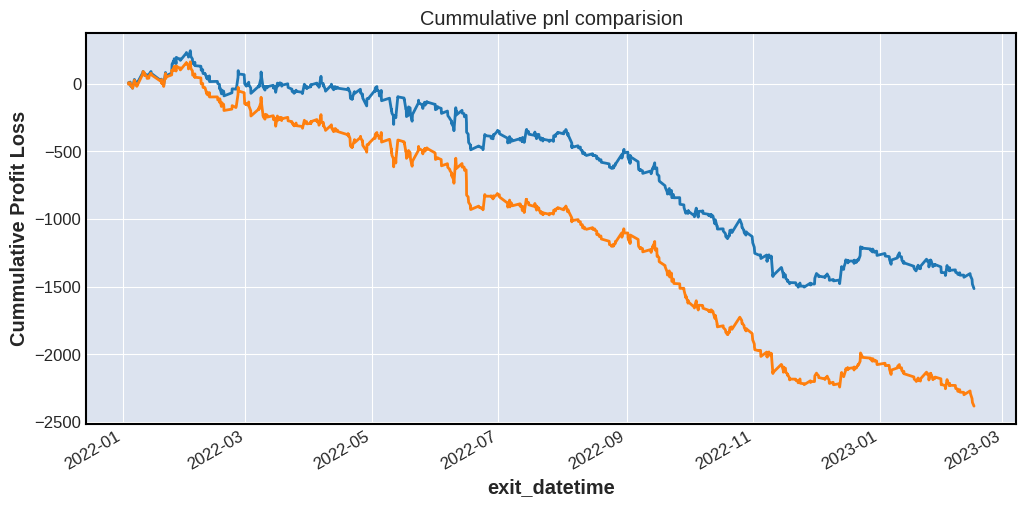

In [121]:
plt.figure(figsize = (12.00, 5.75))
plt.title("Cummulative pnl comparision")
df_trade['CummProfitLoss'].plot()
trade_list['pnl'].cumsum().plot()
plt.ylabel("Cummulative Profit Loss")


## Conclusion



*   The entry, exit times and prices are exactly same in both Vectorbt and Backtrader, but the Cummulative pnl is different.
*   This is because the position sizes are fractional in vectorbt whereas in backtrader, we have rounded the position sizes

